# Melanoma Model Training
[Saliency Cards: A Framework to Characterize and Compare
Saliency Methods](https://arxiv.org/abs/2206.02958) shows examples of saliency methods applied to a melanoma classification model (e.g., Figure 3a). This is the modeling code used to train and evaluate that model. The resulting model is saved as `resources/melanoma_model.pth` and used in the determinism example (`determinism.ipynb`).  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

from torch.utils.data import Dataset, WeightedRandomSampler

We set a variety of training parameters. Update them with your own as needed.

In [17]:
# Dataset Parameters
DATASET_PATH = '/nobackup/users/aboggust/data/isic_melanoma/siim_isic_melanoma_202'
BATCH_SIZE = 128 # used to be: 32
NUM_WORKERS = 40 
SPLIT_PERCENTAGE = 0.8

# Training Parameters
NUM_EPOCHS = 10
LR = 1e-3
MODEL_NAME='resnet50'
MODEL_PATH='melanoma_model.pth'

# Load ISIC Melanoma Data
We train and evaluate our model on the [ISIC Melanoma Dataset](https://www.kaggle.com/competitions/siim-isic-melanoma-classification/overview). It contains images of melanoma lesions labeled as *malignant* or *benign*.

In [18]:
class ISICMelanomaDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor(), min_index=0, max_index=-1):
        self.transform = transform

        data_file = os.path.join(root, 'train.csv')
        self.image_paths = []
        self.labels = []
        with open(data_file) as f:
            reader = csv.reader(f)
            for i, row in enumerate(reader):
                if i == 0: continue # ignore header
                self.image_paths.append(os.path.join(root, 'train', f'{row[0]}.jpg'))
                self.labels.append(int(row[-1]))
        self.image_paths = self.image_paths[min_index: max_index]
        self.labels = self.labels[min_index: max_index]
        
    def __len__(self, ):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        with PIL.Image.open(image_path) as image:
            image = self.transform(image)
        label = self.labels[index]
        return image, label

Transforms are inspired by https://www.kaggle.com/code/tarunpaparaju/siim-isic-melanoma-eda-pytorch-baseline/notebook.

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
])

unnormalize_transform = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
])

In [20]:
dataset = ISICMelanomaDataset(DATASET_PATH, transform=transform)

Since the test targets are not public, we split the training set into 80/20 train/test split.

In [21]:
train_size = int(len(dataset) * SPLIT_PERCENTAGE)
torch.manual_seed(0)
train_dataset = ISICMelanomaDataset(DATASET_PATH, transform=transform, max_index=train_size)
test_dataset = ISICMelanomaDataset(DATASET_PATH, transform=transform, min_index=train_size)
print(f'{len(train_dataset)} training instances and {len(test_dataset)} test instances.')

26500 training instances and 6625 test instances.


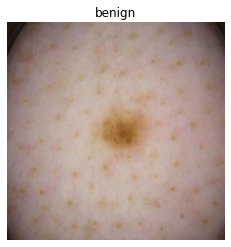

In [22]:
example_image, example_label = test_dataset[0]
plt.imshow(unnormalize_transform(example_image).numpy().transpose(1, 2, 0))
plt.title(f"{'malignant' if example_label==1 else 'benign'}")
plt.axis('off');

The class distributions for *melanoma* and *benign* are 98% to 2%, so we upsample the melanoma images, to help our model learn to distinguish the two classes. If we didn't, the model could guess everything is benign and achieve 98% accuracy.

In [23]:
num_malignant = np.sum(train_dataset.labels)
num_benign = len(train_dataset) - num_malignant
class_counts = [num_benign, num_malignant]
target_proportions = [0.5, 0.5]
sample_weights = [target_proportions[label]/class_counts[label] for label in train_dataset.labels]
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           pin_memory=True, num_workers=NUM_WORKERS,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                          pin_memory=True, shuffle=False, num_workers=NUM_WORKERS)

## Train the Model
We train and evaluate a ResNet50 on the melanoma images. We save the model to `melanoma_model.pth` and use it throughout the saliency examples in Saliency Cards.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.__dict__[MODEL_NAME](pretrained=False, num_classes=2)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

In [26]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LR)

In [27]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    """Performs one training epoch."""
    model.train()
    running_loss = 0
    num_steps = 0
    pbar = tqdm(total=len(train_loader), ncols=120)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_steps += len(data)
        avg_loss = running_loss / num_steps
        
        desciption = f'Epoch {epoch} | Steps {num_steps} | Loss {avg_loss:.4f}'
        pbar.set_description(desciption)
        pbar.update(1)
    pbar.close()            
            
def test(model, device, criterion, test_loader):
    """Tests the model and prints the loss and accuracy."""
    model.eval()
    test_loss = 0
    predictions = []
    probabilities = []
    pbar = tqdm(total=len(test_loader), ncols=120)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # average the batch losses
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred = pred.detach().cpu().numpy().transpose()[0]
            predictions.extend(pred)
            probabilities.extend(output.detach().cpu().numpy())
            
            num_steps = (batch_idx + 1) * len(data)
            avg_loss = test_loss / len(predictions)
            
            desciption = f'Val Epoch {epoch} | Steps {num_steps} | Loss {avg_loss:4f}'
            pbar.set_description(desciption)
            pbar.update(1)
    pbar.close()

    return np.array(predictions), np.array(probabilities)

In [28]:
for epoch in range(NUM_EPOCHS):
    train(model, device, train_loader, optimizer, criterion, epoch)
torch.save(model.state_dict(), MODEL_PATH)

Epoch 0 | Steps 26500 | Loss 0.5518: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 1 | Steps 26500 | Loss 0.4646: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 2 | Steps 26500 | Loss 0.4191: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 3 | Steps 26500 | Loss 0.3917: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 4 | Steps 26500 | Loss 0.3838: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 5 | Steps 26500 | Loss 0.3498: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 6 | Steps 26500 | Loss 0.3187: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 7 | Steps 26500 | Loss 0.3029: 100%|████████████████████████████████████████████| 208/208 [03:15<00:00,  1.06it/s]
Epoch 8 | Steps 26500 | Loss 0.2

After 10 epochs, we evaluate the models predictions and save the model.

In [29]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
predictions, probabilities = test(model, device, criterion, test_loader)

Val Epoch 9 | Steps 5044 | Loss 0.300441: 100%|█████████████████████████████████████████| 52/52 [00:45<00:00,  1.13it/s]


Melanoma prediction is a challenging task. Our model tends to over classify images as cancerous, but in a clinical ML setting where a doctor uses the model to identify images to check, we may prefer a model that is overly cautious about what to show the clinician. 

Our model's AUC score is in line with challenge leaderboard performance. While we may not want to deploy this model in practice, it is sufficient for generating saliency examples.

In [30]:
print(f"Performance after epoch: {epoch+1}:")
print(f"Predicted {np.sum(predictions) / len(predictions):.1%} melanoma. {np.sum(test_dataset.labels) / len(test_dataset.labels):.1%} true melanoma.")
print(f"AUROC {metrics.roc_auc_score(test_dataset.labels, probabilities[:, 1]):.2}")
print(metrics.classification_report(test_dataset.labels, predictions))

Performance after epoch: 10:
Predicted 13.9% melanoma. 1.7% true melanoma.
AUROC 0.84
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      6511
           1       0.06      0.51      0.11       114

    accuracy                           0.86      6625
   macro avg       0.53      0.69      0.52      6625
weighted avg       0.97      0.86      0.91      6625

